# Caliberating on my phone's camera

## 1. Using DLT :

In [20]:
import cv2
import numpy as np
from statistics import mean
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

def getXY(w_pt, i_pt):
    X_list = [-w_pt[0], -w_pt[1], -w_pt[2], -1, 0, 0, 0, 0,
              i_pt[0]*w_pt[0], i_pt[0]*w_pt[1], i_pt[0]*w_pt[2], i_pt[0]]
    Y_list = [0, 0, 0, 0, -w_pt[0], -w_pt[1], -w_pt[2], -1, 
             i_pt[1]*w_pt[0], i_pt[1]*w_pt[1], i_pt[1]*w_pt[2], i_pt[1]]
    return X_list, Y_list

def normalizePoints(i_points):
    mean_X = mean(i_points[:][0])
    mean_Y = mean(i_points[:][1])
    np_X = i_points[:, 0] - mean_X
    np_Y = i_points[:, 1] - mean_Y
    dist = []
    for x,y in zip(np_X,np_Y):
        dist.append(math.sqrt(x**2 + y**2))
    mean_dist = mean(dist)
    scale = math.sqrt(2)/mean_dist
    T = [[scale, 0, -scale*mean_X], [0, scale, -scale*mean_Y], [0, 0, 1]]
    H_i_points = np.c_[ i_points, np.ones(len(img_points))]
    H_i_points = [np.dot(T, x) for x in H_i_points]
    H_i_points = np.delete(H_i_points, -1, axis = 1)
    return H_i_points

def reprojection_error(objpoints3d, imgpoints2d, rvecs, tvecs, mtx):
    mean_error = 0
    for i in range(len(objpoints3d)):
        projected_point = projectOnImg(objpoints3d[i], rvecs, tvecs, mtx)
        #imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(np.float32(imgpoints2d[i]),np.float32(projected_point), cv2.NORM_L2)
        mean_error += error
    
    print ("total error: ", mean_error/len(objpoints3d))
    return mean_error/len(objpoints3d)

def projectOnImg(objpoint, rvecs, tvecs, mtx):
    #dst, jacobian = cv2.Rodrigues(rvecs)
    P = np.dot(mtx, rvecs)
    t = np.dot(mtx,tvecs)
    #print(P.shape, mtx.shape)
    xy = np.dot(P,np.c_[objpoint]) + t
    xy = (xy/xy[2][0])
    return [int(xy[0][0]), int(xy[1][0])]
                        
def executeRANSAC(world3d, img2d, max_iters, samples_to_fit, error_thresh):
    best_points = None
    min_err = 0
    num_samples = img2d.shape[0]
    cam_mat = []
    rot_mat = []
    t_mat = []
    for i in range(max_iters):
        sample = np.random.choice(num_samples, size=samples_to_fit, replace=False)
        mtx, rvecs, tvecs, P, X = findProjectionMatrix(world3d[sample], img2d[sample])
        err = reprojection_error(world3d[sample], img2d[sample], rvecs, tvecs, mtx)
        if err > error_thresh:
            continue
        best_points = sample
        min_err = err
        cam_mat = mtx
        rot_mat = rvecs
        t_mat = tvecs
    return best_points, min_err, cam_mat, rot_mat, t_mat

def findProjectionMatrix(world3d, img2d):
    M = []
    for i in range (6):
        #X_list, Y_list = getXY(world_points[(i*119)%38], norm_img_points[(i*119)%38])
        X_list, Y_list = getXY(world_points[i], norm_img_points[i])
        M.append(X_list)
        M.append(Y_list)
    u, s, vh = np.linalg.svd(M, full_matrices=True)
    v = vh.transpose()
    P = np.array([v[0:4,11], v[4:8,11], v[8:12,11]])
    H_inf = P[0:3,0:3]
    H_inf_inv = np.linalg.inv(H_inf)
    m4 = P[:, 3]
    X_minus = np.dot(H_inf_inv, m4)
    X = (-1)*X_minus
    Q, R = np.linalg.qr(H_inf_inv)
    np.allclose(H_inf_inv, np.dot(Q, R))  # a does equal qr
    Rot_inv = Q
    rvec = np.linalg.inv(Q)
    K_inv = R
    K = np.linalg.inv(K_inv)
    K = K/K[2,2]
    tvec = np.dot(rvec,X_minus)
    return K, rvec, tvec, P, X


def plot3dview(points_3d, camera_center):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='blue',
        marker='o', s=10, depthshade=0)
    camera_center = camera_center.squeeze()
    ax.scatter(camera_center[0],  camera_center[1], camera_center[2], c='red',
        marker='x', s=20, depthshade=0)

    # draw vertical lines connecting each point to ground
    min_z = min(points_3d[:, 2])
    for p in points_3d:
        x, y, z = p
        ax.plot3D(xs=[x, x], ys=[y, y], zs=[z, min_z], c='black', linewidth=1)
    x, y, z = camera_center
    ax.plot3D(xs=[x, x], ys=[y, y], zs=[z, min_z], c='black', linewidth=1)
    
def evaluate_points(M, points_2d, points_3d):
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

def visualize_points(actual_pts, projected_pts):
    _, ax = plt.subplots()
    ax.scatter(actual_pts[:, 0], actual_pts[:, 1], c='red', marker='o',
        label='Actual points')
    ax.scatter(projected_pts[:, 0], projected_pts[:, 1], c='green', marker='+',
        label='Projected points')
    ax.legend()

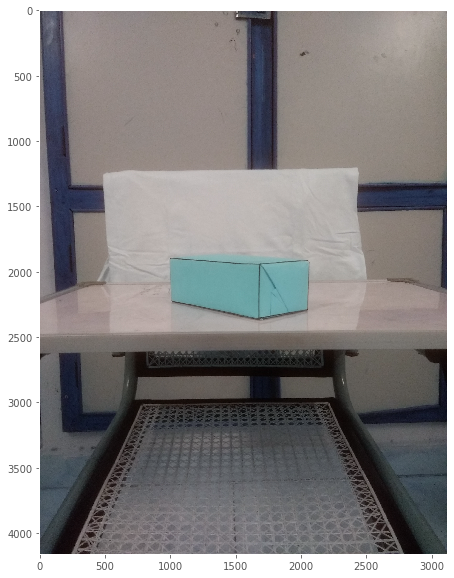

total error:  2663.5235850902836
total error:  2663.5235850902836
total error:  2663.523585090283
total error:  2663.5235850902836
total error:  2663.5235850902836
total error:  2663.5235850902836
total error:  2663.5235850902836
total error:  2663.523585090283
total error:  2663.5235850902836
total error:  2663.5235850902836
Minimum error :
 2663.5235850902836
Camera matrix :
 [[ 2.12425397e+03  1.25564994e+01  1.88806467e+03]
 [-0.00000000e+00 -2.11893506e+03  2.08691450e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation matrix for 1st image:
 [[-0.64440484  0.7646517  -0.0070836 ]
 [-0.0919041  -0.08664117 -0.9919914 ]
 [-0.75914164 -0.63859305  0.12610662]]
Translation matrix for 1st image :
 [  2.55620581   3.9766361  -27.08677442]


In [22]:
img = cv2.imread("mycam_data/IMG_1x_1.jpg")

plt.figure(figsize=(10,10))
plt.grid(b=None)
plt.imshow(img)
plt.show()

#### Zoom-1x
img_points = [[1684,2398], [2058,2293], [2065,1916], [1688,1936], [1014,2226], [1000,1896]]
img_points = np.asarray(img_points)

world_points = [[0,0,0], [8.1,0,0], [8.1,0,5.9], [0,0,5.9], [0,17.1,0], [0,17.1, 5.9]]
world_points = np.asarray(world_points)
####

norm_img_points = img_points #normalizePoints(img_points)

M = []
for i in range (6):
    #X_list, Y_list = getXY(world_points[(i*119)%38], norm_img_points[(i*119)%38])
    X_list, Y_list = getXY(world_points[i], norm_img_points[i])
    #print((i*119)%38)
    M.append(X_list)
    M.append(Y_list)

best_points, min_err, cam_mat, rot_mat, t_mat = executeRANSAC(world_points, norm_img_points, 10, 6, 2700)
print("Minimum error :\n", min_err)
print("Camera matrix :\n", cam_mat)
print("Rotation matrix for 1st image:\n",rot_mat)
print("Translation matrix for 1st image :\n",t_mat)

Projection matrix :
 [[ 3.52602650e-02 -5.25156018e-03 -2.64884039e-03  5.74329051e-01]
 [ 1.74773590e-02  1.44533358e-02 -2.97485750e-02  8.16987643e-01]
 [ 9.54843720e-06  8.03218437e-06 -1.58616133e-06  3.40695793e-04]]


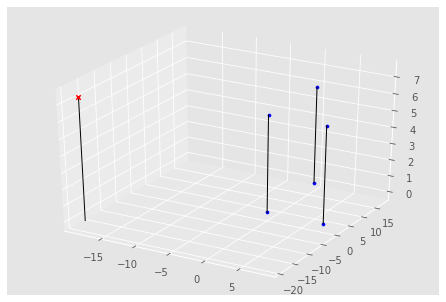

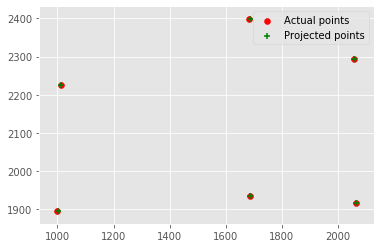

In [23]:
K, rvec, tvec, P, cam_center = findProjectionMatrix(world_points[best_points], norm_img_points[best_points])
print("Projection matrix :\n", P)
plot3dview(world_points, cam_center)
points_3d_proj, residual = evaluate_points(P, norm_img_points, world_points)
visualize_points(norm_img_points, points_3d_proj)

## 2. Using Zhangs method :

In [ ]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
#from matplotlib import style
#style.use("ggplot")

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((8*6,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('mycam_data/chessboard_1x/*.jpg') #("mycam_data/chessboard_1x/*.jpg")
#print(images)
img_to_show= []
i=0
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (8,6), None)
    #print(ret)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (8,6), corners2, ret)
        img_to_show = img
        cv.imwrite("q3_op/img_"+str(i)+".jpg", img)
        i=i+1
        cv.imshow('img', img)
        #cv.waitKey(500)
cv.destroyAllWindows()
plt.figure(figsize=(15,10))
plt.grid(b=None)
plt.imshow(img_to_show);
plt.show();
cv.destroyAllWindows()

In [15]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#print(ret)
print("Camera matrix :\n", mtx)
print("Distortion matrix :\n",dist)
print("Rotation matrix for 1st image:\n",rvecs[0])
print("Translation matrix for 1st image :\n",tvecs[0])

Camera matrix :
 [[3.27054542e+03 0.00000000e+00 1.63429944e+03]
 [0.00000000e+00 3.30205443e+03 2.06217865e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion matrix :
 [[ 1.53016399e-01 -6.77183950e-01 -9.99885889e-04  2.44330084e-02
   3.74743657e+00]]
Rotation matrix for 1st image:
 [[ 0.0655073 ]
 [-0.03135368]
 [ 0.01567144]]
Translation matrix for 1st image :
 [[-3.80320166]
 [-3.66367848]
 [16.29104669]]


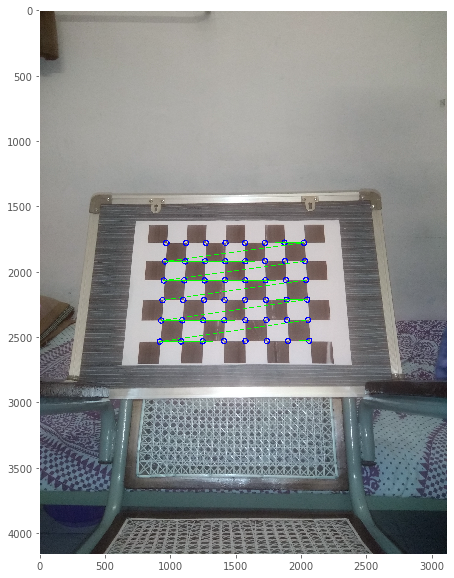

In [16]:
img_to_show= []
for i in range(len(images)):
    img = cv.imread(images[i])
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    dst, jacobian = cv.Rodrigues(rvecs[i])
    #print(rvecs[i].shape, dst.shape)
    P = np.dot(mtx, dst)
    t = np.dot(mtx,tvecs[i])
    points_plot = []
    for j in range(len(objpoints[0])):
        xy = np.dot(P,np.c_[objpoints[i][j]]) + t#np.transpose(np.dot(P,tvecs[i]))
        xy = (xy/xy[2][0])
        points_plot.append((int(xy[0][0]), int(xy[1][0])))
    img = cv.circle(img, points_plot[0], radius=20, color=(0,0,255), thickness=8)
    for pt in range(len(points_plot)-1):
        img = cv.circle(img, points_plot[pt+1], radius=20, color=(0,0,255), thickness=8) 
        img = cv.line(img, points_plot[pt], points_plot[pt+1], color=(0,255,0), thickness=4) 
        img_to_show = img
    cv.imshow('img', img)
    cv.imwrite("q3_op/img_"+str(i)+".jpg", img)
    #cv.waitKey(500)

plt.figure(figsize=(15,10))
plt.grid(b=None)
plt.imshow(img_to_show)
plt.show();
cv.destroyAllWindows()